## Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [2]:
data = pd.read_csv(
Path("../data/XRPUSDT1H.csv"), parse_dates = ["Date"], index_col = "Date")

data.columns=(["Open", "High", "Low", "Close", "Volume"])

data.info()

data = data[["Close"]].copy()


data["returns"] = np.log(data.Close.div(data.Close.shift(1)))


SMA_S = 15
SMA_M = 50
SMA_L = 200

data["SMA_S"] = data.Close.rolling(window = SMA_S).mean()
data["SMA_M"] = data.Close.rolling(window = SMA_M).mean()
data["SMA_L"] = data.Close.rolling(window = SMA_L).mean()

In [12]:
data

,Close,returns,SMA_S,SMA_M,SMA_L
Date,,,,,
2017-08-20 00:00:00,0.90199,NaN,NaN,NaN,NaN
2017-08-20 01:00:00,0.90128,-0.000787,NaN,NaN,NaN
2017-08-20 02:00:00,0.91596,0.016157,NaN,NaN,NaN
2017-08-20 03:00:00,0.90098,-0.016490,NaN,NaN,NaN
2017-08-20 04:00:00,0.89722,-0.004182,NaN,NaN,NaN
...,...,...,...,...,...
2021-04-18 21:00:00,0.82700,0.002421,0.831013,0.836932,0.849617
2021-04-18 22:00:00,0.82860,0.001933,0.831160,0.836478,0.849094
2021-04-18 23:00:00,0.82990,0.001568,0.831307,0.836038,0.848550


In [13]:
data.dropna(inplace = True)

In [14]:
smas = ["SMA_S", "SMA_M", "SMA_L"]
smas

data["position"] = 0 # Trading position -> Neutral for all bars
data

cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
cond1

cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
cond2

data.loc[cond1, "position"] = 1
data.loc[cond2, "position"] = -1

In [20]:
data.position.value_counts()

 0    12933
-1    10332
 1     8650
Name: position, dtype: int64

In [22]:
data.tail()

,Close,returns,SMA_S,SMA_M,SMA_L,position
Date,,,,,,
2021-04-18 21:00:00,0.8270,0.002421,0.831013,0.836932,0.849617,-1
2021-04-18 22:00:00,0.8286,0.001933,0.831160,0.836478,0.849094,-1
2021-04-18 23:00:00,0.8299,0.001568,0.831307,0.836038,0.848550,-1
2021-04-19 00:00:00,0.8228,-0.008592,0.830853,0.835440,0.847993,-1
2021-04-19 01:00:00,0.8276,0.005817,0.830793,0.834874,0.847368,-1


## Backtesting

In [23]:
class Long_Short_Backtester():
    ''' Class for backtesting of Long-Short trading strategy

    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy.
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
               
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
    
        '''
        
        Parameters
        ============
        smas:  (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            

        

    ############################## Performance ######################################
    
    def print_performance(self):
        
        
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [24]:
filepath = ("../data/XRPUSDT1H.csv")
symbol = "XRPUSDT"
start = "2017-08-28"
end = "2021-10-07"
tc = -0.00085 # futures trading cost
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [25]:


tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [26]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-28 00:00:00,0.64450,0.68470,0.64089,0.68070,918122.87,NaN
2017-08-28 01:00:00,0.68070,0.70400,0.67510,0.70295,1814859.36,0.032164
2017-08-28 02:00:00,0.70295,0.70500,0.67970,0.69098,1190620.15,-0.017175
2017-08-28 03:00:00,0.69098,0.71000,0.69098,0.70217,1107023.39,0.016065
2017-08-28 04:00:00,0.70221,0.70602,0.67900,0.67900,890335.31,-0.033554
...,...,...,...,...,...,...
2021-04-18 21:00:00,0.82510,0.83010,0.82340,0.82700,6009115.00,0.002421
2021-04-18 22:00:00,0.82700,0.83030,0.82490,0.82860,5856313.00,0.001933
2021-04-18 23:00:00,0.82850,0.83070,0.82690,0.82990,4370343.00,0.001568


In [27]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = XRPUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         14.823956
Multiple (Buy-and-Hold):     1.200987
--------------------------------------
Out-/Underperformance:       13.622969


CAGR:                        1.107491
Annualized Mean:             0.745122
Annualized Std:              0.995521
Sharpe Ratio:                1.112474


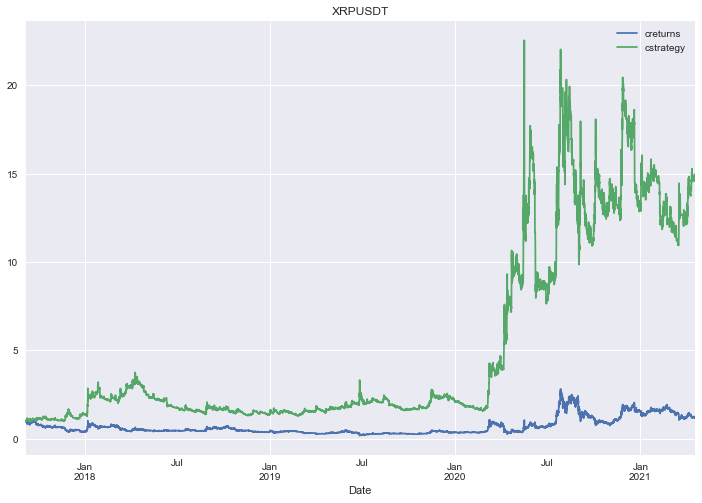

In [32]:
tester.plot_results()

In [35]:
tester.results

,Close,returns,SMA_S,SMA_M,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,
2017-09-05 07:00:00,0.69520,0.008813,0.683783,0.676368,0.691450,0,NaN,0.0,1.008852,NaN
2017-09-05 08:00:00,0.69910,0.005594,0.684729,0.677120,0.691542,0,0.000000,0.0,1.014512,1.000000
2017-09-05 09:00:00,0.70099,0.002700,0.686100,0.677800,0.691532,0,0.000000,0.0,1.017254,1.000000
2017-09-05 10:00:00,0.70117,0.000257,0.687465,0.678616,0.691583,0,0.000000,0.0,1.017516,1.000000
2017-09-05 11:00:00,0.70412,0.004198,0.689036,0.679278,0.691593,0,0.000000,0.0,1.021797,1.000000
...,...,...,...,...,...,...,...,...,...,...
2021-04-18 21:00:00,0.82700,0.002421,0.831013,0.836932,0.849617,-1,-0.002421,0.0,1.200116,14.834711
2021-04-18 22:00:00,0.82860,0.001933,0.831160,0.836478,0.849094,-1,-0.001933,0.0,1.202438,14.806066
2021-04-18 23:00:00,0.82990,0.001568,0.831307,0.836038,0.848550,-1,-0.001568,0.0,1.204324,14.782873


In [36]:
tester.results.trades.value_counts()

0.0    30756
1.0      963
2.0        4
Name: trades, dtype: int64